In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import shap

from utilsPlots import *

cp = ['#117733', '#44AA99', '#332288', '#88CCEE', '#D0AB41', '#CC6677', '#882255']


In [3]:
datadir = Path('../../datadir')

figdir = Path('./figs')
figdir.mkdir(exist_ok=True, parents=True)


In [4]:
df_info = pd.read_csv(datadir / 'participant_info.csv')
df_feat = pd.read_csv(datadir / 'video_features.csv')
df_all = df_info.merge(df_feat, on=['ID', 'day'])

df_feat_key = pd.read_csv(datadir / 'feature_key.csv')
oc_feats = df_feat_key.feature_code.values.tolist()
tft_feats = ['tft_10mwrt', 'tft_10mwt', 'tft_5xsts', 'tft_tug', 'brooke_score']

feat_name_map = dict(zip(df_feat_key.feature_code, df_feat_key.name))


In [5]:
def compute_shap_values(df, feats, label):
    X = df[feats].values
    y = df[label].values
    groups = df.ID.values
    
    p_grid = {'svc__C': np.logspace(-1, 2, 8)}
    
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(random_state=0, probability=True))
    ])
    inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)
    
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, y)    
    
    f = lambda x : clf.predict_proba(x)[:,1]
    explainer = shap.Explainer(f, X)
    shap_values = explainer(X)
    
    df_imp = pd.DataFrame({'shap': np.abs(shap_values.values).mean(axis=0), 'feat':feats})
    df_imp = df_imp.sort_values('shap', ascending=True).reset_index(drop=True)

    return df_imp


def plot_shap_values(df_imp, figsize=(6.5,8), xlim=(0, 0.06), saveto=None):
    plt.figure(figsize=figsize)
    for i, row in df_imp.iterrows():
        if row.feat.startswith('10mwrt'):
            c = cp[0]
        elif row.feat.startswith('10mwt'):
            c = cp[1]
        elif row.feat.startswith('tug'):
            c = cp[2]
        elif row.feat.startswith('5xsts'):
            c = cp[3]
        elif row.feat.startswith('brooke') or row.feat.startswith('arm_rom') or row.feat.startswith('curls'):
            c = cp[4]
        elif row.feat.startswith('toe_stand'):
            c = cp[5]
        else:
            c = cp[6]
        plt.barh(y=i, width=row.shap, color=c)
        
        s = feat_name_map.get(row.feat, row.feat)
        if row.shap < xlim[-1]*0.4:
            plt.text(x=row.shap+0.0003, y=i-0, s=s,
                     size='medium', va='center', c=c, weight='bold')
        else:
            plt.text(x=row.shap-0.0003, y=i-0, s=s,
                     size='medium', va='center', ha='right', c='#ffffff', weight='bold')
    
    plt.ylim(-1,len(df_imp))
    plt.xlim(xlim)
    plt.xticks([xlim[0], xlim[1]])
    sns.despine(left=True)
    plt.yticks([])
    plt.tight_layout()
    if saveto:
        plt.savefig(figdir / saveto)
    plt.show()


In [6]:
feats = oc_feats
df = df_all[df_all.type.isin(['FSHD', 'TYP'])].copy()
df['label'] = df.type=='FSHD'
print('n =', df.ID.nunique())

df_imp_fshd_vs_typ = compute_shap_values(df, feats, 'label')


n = 71


Permutation explainer: 87it [00:17,  2.23it/s]                                                                                                   


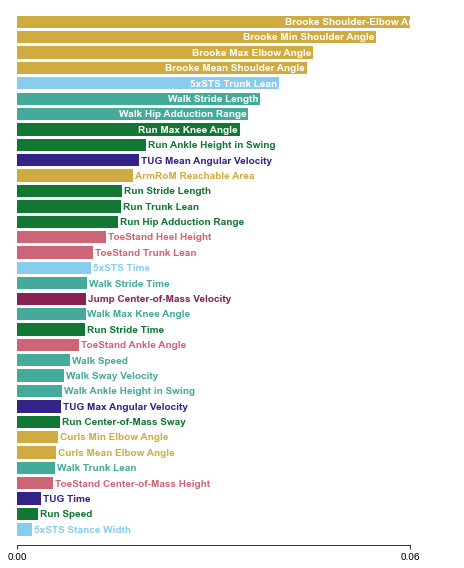

In [7]:
plot_shap_values(df_imp_fshd_vs_typ, saveto='fig7a_shap_fshd.pdf')


In [8]:
feats = oc_feats
df = df_all[df_all.type.isin(['DM', 'TYP'])].copy()
df['label'] = df.type=='DM'
print('n =', df.ID.nunique())

df_imp_dm_vs_typ = compute_shap_values(df, feats, 'label')


n = 101


Permutation explainer: 128it [00:40,  2.40it/s]                                                                                                  


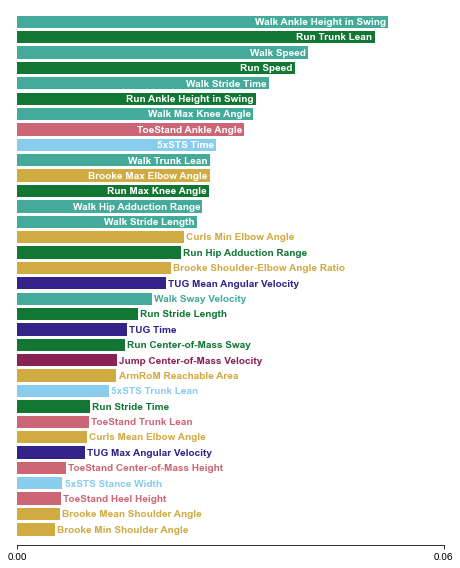

In [10]:
plot_shap_values(df_imp_dm_vs_typ, saveto='fig7b_shap_dm.pdf')
